# Inferential Analysis

### Feature selection

As discovered during EDA, there is high multicolinearity in our feature set. We'll reference the association heatmaps in the EDA notebook. 

To begin, we'll address the redundancy between 'Admission grade' and 'Previous qualification (grade)' by removing whichever one has lower mutual information with the target. 

In [2]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

X = pd.read_csv('LogReg/X.csv')
y = pd.read_csv('LogReg/y.csv')

y_np = y.to_numpy()
y_np = y_np.ravel()

ag = mutual_info_classif(X['Admission grade'].to_frame(), y_np, discrete_features=False, random_state=1)
pqg = mutual_info_classif(X['Previous qualification (grade)'].to_frame(), y_np, discrete_features=False, random_state=1)

print(f'Admission grade: {ag}\nPrevious qualification (grade): {pqg}')

Admission grade: [0.02852458]
Previous qualification (grade): [0.0357418]


We'll remove 'Admission grade'.

We'll also remove 'International' because it's completely redundant with 'Nationality' but provides less information.

Next, we'll address the fact that 'Course' and 'Daytime/evening attendance' are one for one associated. We'll remove 'Daytime/evening attendance' because it's redundant with 'Course', which contains more information.

Curricular units (enrolled), for both 1st and 2nd semesters, are highly associated with 'Course'. However, we should be careful about removing either since they provide very different types of information. Let's compare their relatinships to the target using mutual information. We can't compare VIF scores since one feature is categorical. 

In [3]:
# COMPARE MUTUAL INFORMATION
c = mutual_info_classif(X['Course'].to_frame(), y_np, discrete_features=True, random_state=1)
cu = mutual_info_classif(X['Curricular units 1st sem (enrolled)'].to_frame(), y_np, discrete_features=False, random_state=1)

print(f'Course: {c}\nCurricular units 1st sem (enrolled): {cu}')

Course: [0.03455513]
Curricular units 1st sem (enrolled): [0.02378636]


In [4]:
# REMOVE REDUNDANT FEATURES

X = X.drop(['Admission grade', 'Daytime/evening attendance', 'International'], axis=1)

It's still not clear if it's suitable to remove one or the other. Let's keep both for now and choose one based on model performance later.

Now we need to address the high multicolinearity among all the features measuring curricular units. Let's try using PCA.<br>
First, we'll try PCA using all the features. This probably won't yield good results as most of the features aren't correlated amongst each other. Then, we'll try using subset PCA, wherein only the curricular unit features are transformed and the other features are left unchanged.

In [5]:
from sklearn.decomposition import PCA

curr_units = [
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)'
]

# ALL FEATURES
pca_all = PCA(n_components=3)
pca_all.fit(X)

# CURR UNITS FEATURES
pca_cu = PCA(n_components=3)
pca_cu.fit(X[curr_units])

print(f'All features:\n{pca_all.explained_variance_ratio_}\n\nCurr Units features:\n{pca_cu.explained_variance_ratio_}')

All features:
[9.99840289e-01 7.80459674e-05 4.11694210e-05]

Curr Units features:
[0.64980168 0.25016538 0.05229662]


The components of pca_all explain almost no variance, whereas the first two components of pca_cu explain 90% of it. We'll replace all the curricular unit features with these two components. This also resolves the 'Curricular units (enrolled)' vs 'Course' issue.

In [6]:
# REPLACE CURR UNITS FEATURES WITH PRINCIPLE COMPONENTS

pca_cu = PCA(n_components=2)
transformed = pca_cu.fit_transform(X[curr_units])

pca_df = pd.DataFrame(transformed, columns=[f'Curr units PC{i+1}' for i in range(transformed.shape[1])])
X = X.drop(curr_units, axis=1)
X = pd.concat([X, pca_df], axis=1)

In [6]:
X.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Previous qualification', 'Previous qualification (grade)',
       'Nationality', 'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment',
       'Unemployment rate', 'Inflation rate', 'GDP', 'Curr units PC1',
       'Curr units PC2'],
      dtype='object')

### Model 1

Before we model, let's define functions for scaling and one-hot encoding the data that will handle the combination of categorical and numeric features.

In [7]:
''' 
Function to scale data without altering nominal features.
Takes 'df' (a dataframe) and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe. 
'''

from sklearn.preprocessing import MinMaxScaler

def scale(df, nominal):

    scaler = MinMaxScaler()

    for var in df.columns:
            
        if var not in nominal:
            raw = df[var].to_numpy()
            raw = raw.reshape(-1, 1)

            scaler.fit(raw)
            scaled = scaler.transform(raw)
            df[var] = scaled

    return df

In [8]:
''' 
Function to one-hot encode data without altering non-nominal features.
Takes 'df' (a dataframe) and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe.
'''

from sklearn.preprocessing import OneHotEncoder

def one_hot(df, nominal):

    # initialize encoder object
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', drop='first')

    # subset data
    df_nom = df[nominal]

    # fit
    fit = encoder.fit(df_nom)
    
    # transform
    encoded = encoder.transform(df_nom)

    # convert result to df
    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(nominal))

    # add results to full data
    data_one_hot = pd.concat([df.reset_index(drop=True), 
                              one_hot_df.reset_index(drop=True)], 
                              axis=1)

    # drop original nominal columns
    data_one_hot = data_one_hot.drop(nominal, axis=1)

    return data_one_hot

In [9]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# preprocess
nominal = ['Marital status', 'Application mode', 'Course',
       'Previous qualification', 'Nationality', "Mother's qualification", 
       "Father's qualification", "Mother's occupation", "Father's occupation", 
       'Displaced', 'Educational special needs', 'Debtor', 
       'Tuition fees up to date','Gender', 'Scholarship holder']

X_scale = scale(X, nominal)

X_oh = one_hot(X_scale, nominal)

# add intercept
X_oh = sm.add_constant(X_oh)

# fit
clf = sm.Logit(y, X_oh)
clf_fit = clf.fit(method='lbfgs') # binary features mean the model won't converge with default regularization

# summary stats
print(clf_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 4424
Model:                          Logit   Df Residuals:                     4322
Method:                           MLE   Df Model:                          101
Date:                Tue, 29 Oct 2024   Pseudo R-squ.:                  0.4755
Time:                        17:56:47   Log-Likelihood:                -1456.8
converged:                      False   LL-Null:                       -2777.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              9.8580      1.379      7.149      0.000       7.155      12.561
Application order                  0.5456      0.393      1.389      0.

c:\Users\Melanie\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# convert features summary table to dataframe
fit_df = (clf_fit.summary2().tables[1])

#convert feature names from row index labels to column
fit_df = fit_df.reset_index()
fit_df = fit_df.rename(columns={'index': 'Var'})
fit_df

,Var,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
0,const,9.858034,1.378938,7.149003,8.741066e-13,7.155364,12.560703
1,Application order,0.545608,0.392781,1.389088,1.648059e-01,-0.224229,1.315445
2,Previous qualification (grade),0.094480,0.367785,0.256888,7.972650e-01,-0.626365,0.815324
3,Age at enrollment,1.548346,0.500971,3.090692,1.996909e-03,0.566461,2.530230
4,Unemployment rate,0.838582,0.183842,4.561427,5.080707e-06,0.478258,1.198905
...,...,...,...,...,...,...,...
97,Educational special needs_1,0.279111,0.403249,0.692155,4.888400e-01,-0.511243,1.069464
98,Debtor_1,0.559162,0.161705,3.457912,5.443782e-04,0.242226,0.876097
99,Tuition fees up to date_1,-2.729947,0.186780,-14.615828,2.226324e-48,-3.096029,-2.363865
100,Gender_1,0.492037,0.110659,4.446432,8.730833e-06,0.275150,0.708925


The categorical features present a problem. Because each one-hot encoded feature has its own p-value and coefficient, we can't determine feature importance or significance just by looking at the summary statistics. We'll use a likelihood ratio test to determine significance, and simply sum the coefficients to estimate importance. The downside to this is that we must sum the absolute values of the coefficients, and thus we lose the directionality. We'd have to look at the individual coefficients to determine direction. 

Build a new dataframe with the unaltered statistics for ordinal features and aggregated statistics for categorical features.

In [ ]:
# I can't get the likelihood ratio tests included in statsmodels to work, so I'll write my own 
def lr_test(reduced_model):
    import scipy.stats as stats

    # get log likelihoods for each model
    ll_full = clf_fit.llf
    ll_reduced = reduced_model.llf

    lr_stat = -2 * (ll_reduced - ll_full) # test statistic
    df_diff = clf.df_model - reduced_model.df_model  # difference in degrees of freedom between models
    lr_p_value = stats.chi2.sf(lr_stat, df_diff) # p-value

    return lr_p_value

coefs = []
p = []
oh_var_list = fit_df['Var'].to_list()

for var1 in nominal:
    sum_abs = 0
    to_drop = []

    for var2 in oh_var_list:
        if var1 in var2:
            sum_abs =+ float(abs(fit_df[fit_df['Var']==var2]['Coef.']).values) 
            to_drop.append(var2)

    coefs.append(sum_abs)

    reduced_model = sm.Logit(y, X_oh.drop(columns=to_drop)).fit(method='ncg')
    p.append(lr_test(reduced_model))
    
cat_df = pd.DataFrame({'Var': nominal,
                       'Abs_coef': coefs,
                       'p': p})
cat_df

Let's find all the features with non-significant p-values so that we can remove them.

In [12]:
ordinal = [var for var in X.columns if var not in nominal]
not_sig = fit_df[(fit_df['P>|z|'] > 0.05) & (fit_df['Var'].isin(ordinal))]['Var'].tolist() + cat_df[cat_df['p'] > 0.05]['Var'].tolist()

print('Features with non-significant coefficients:\n')
print(not_sig)

Features with non-significant coefficients:

['Application order', 'Previous qualification (grade)', 'Inflation rate', 'GDP', 'Marital status', 'Application mode', 'Previous qualification', 'Nationality', "Father's qualification", 'Displaced', 'Educational special needs']


Build a dataframe containing all the features and their importances so that we can plot them. 

In [25]:
# make sure the columns match between the dataframes
fit_df = fit_df.drop(['Std.Err.', 'z', '[0.025', '0.975]'], axis=1)
fit_df = fit_df.rename(columns={'P>|z|': 'p', 'Coef.': 'Coef'})
cat_df = cat_df.rename(columns={'Abs_coef': 'Coef'})

# concatenate the dataframes, filtering out non-significant features
sig_df = pd.concat([fit_df[(fit_df['p'] <= 0.05) & (fit_df['Var'].isin(ordinal))], cat_df[cat_df['p'] <= 0.05]], axis=0)
sig_df['Coef'] = abs(sig_df['Coef'])
sig_df

,Var,Coef,p
3,Age at enrollment,1.548346,1.996909e-03
4,Unemployment rate,0.838582,5.080707e-06
7,Curr units PC1,9.714065,9.597072e-78
8,Curr units PC2,9.821509,2.280760e-73
2,Course,0.675793,9.278009e-44
5,Mother's qualification,1.077580,3.711425e-02
7,Mother's occupation,0.024571,2.298483e-04
8,Father's occupation,0.539222,1.642173e-02
11,Debtor,0.559162,9.533835e-03
12,Tuition fees up to date,2.729947,1.986257e-56


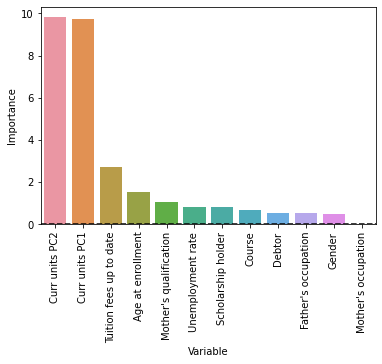

In [29]:
import seaborn as sns

# sort dataframe
sig_df = sig_df.sort_values(by='Coef', ascending=False)

# plot coefficients
g = sns.barplot(data=sig_df, x='Var', y='Coef')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Variable')
g.set_ylabel('Importance')
g.axhline(y=0, color='black', linestyle='--')


The constant coefficient is 9.85, which is about equal to the most important features. This means our model's baseline probability is not 50%, and the predictive model should have a strong bias toward one error type over the other.

The most important features are:
1. Curr units PC2
2. Curr Units PC1
3. Tuition fees up to date
4. Age at enrollment
5. Mother's qualification
6. Unemployment rate
7. Scholarship holder
8. Course
9. Debtor
10. Father's occupation
11. Gender

Mother's occupation has a statistically significant coefficient, but the actual magnitude is negligable. 

Even though some of these features have small coefficients, that doesn't mean they aren't useful in a predictive model. Even including the non-significant features may improve the model's metrics. This analysis is meant to help us understand which factors are important to examine in the student population. 


Because we've had to take the absolute value of all the coefficients due to the nature of one-hot encoding, this plot doesn't show us the direction of the relationships. Let's plot the coefficients of the encoded features so that we can try to determine directionality for the categorical features. 

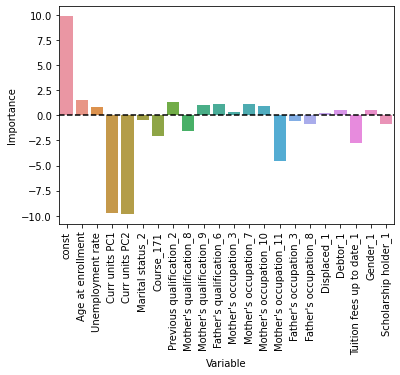

In [30]:
fit_df_sig = fit_df[fit_df['p'] <= 0.05]

g = sns.barplot(data=fit_df_sig, x='Var', y='Coef')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Variable')
g.set_ylabel('Importance')
g.axhline(y=0, color='black', linestyle='--')

### Conclusion 

Curricular units:<br>
This is by far the most important factor. There is a very strong inverse relationship between number of curricular units and chance of graduating. 

Tuition fees up to date:<br>
Predictably, those struggling to pay tuition are likely to dropout. This is the second most important factor. 

Age at enrollment:<br>
Older individuals are more likely to dropout.

Scholarship holder:<br>
Students with scholarships are less likely to dropout.

Debtor:<br>
Debtors are slightly more likely to dropout. 

Gender:<br>
Males are more likely to dropout (males are encoded as 0). This may be because males often aspire for the trades and the military, whereas females have few obvious pathways outside of education that aren't male dominated. This means that preventing male students from dropping out may be a matter of career counseling, but more investigation is needed to determine that.

Course:<br>
Students majoring in Animation and Multimedia Design are more likely to dropout than the other majors in the sample. This requires more analysis, since the sample included only 17 majors, some of which are probably not very popular (such as equinculture).

Marital status:<br>
Married students are slightly more likely to dropout, but not enough to be concerning. 

Mother's occupation:<br>
Mother's occupation has more effect than father's occupation, with different categories affecting the probability of dropping out in different directions. Most of these effects are relatively small. The exception is for cleaning workers, whose children are much more likely to dropout than any other occupation category. The importance of the feature as a whole mainly comes from this one category. 

Father's occupation:<br>
Father's occupation doesn't have much relationship with dropping out. Only 2 of the 12 categories have a very small effect. 